# MLP for Stock Returns Prediction

Build a 3-layer MLP to predict daily stock returns using yfinance futures data (e.g., CL=F for crude oil). Experiment with SGD vs. Adam and batch norm vs. none. Log training curves.

We import libraries for data fetching (yfinance), data processing (pandas, numpy), ML (torch, sklearn), and experiment tracking. These handle everything from pulling stock data to training the neural network and logging results. You’ve likely used numpy and pandas for data manipulation and torch for basic neural nets.

In [1]:
import random
import numpy as np
import torch
from torch import nn
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed = 42  # Pick your poison — any int works

random.seed(seed)                    # Python's built-in RNG
np.random.seed(seed)                 # NumPy RNG
torch.manual_seed(seed)              # PyTorch CPU RNG
torch.cuda.manual_seed(seed)         # PyTorch GPU RNG (if you have CUDA)
torch.cuda.manual_seed_all(seed)     # All GPUs (multi-GPU setups)

# For deterministic results (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

We use yfinance to fetch daily adjusted closing prices for crude oil futures (CL=F) from May 1, 2023, to May 1, 2025. We compute log returns (ln(price_t / price_{t-1})) to make the data stationary, which is standard for financial time series since raw prices are non-stationary. Dropping NaNs ensures clean data. Log returns are used because they’re additive and better for ML models.

In [2]:
data = yf.download('CL=F', start='2023-05-01', end='2025-05-01')
df = data['Close']
returns = np.log(df / df.shift(1)).dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Let us print what we created so we can see that we shifted the close price by one and then divided each price by it's succeding one so that we have an idea about how on average the future's price vary. Then we logged the returns for stability.

In [3]:
print(df.head())
print(df.shift(1).head())
print(returns)

Ticker           CL=F
Date                 
2023-05-01  75.660004
2023-05-02  71.660004
2023-05-03  68.599998
2023-05-04  68.559998
2023-05-05  71.339996
Ticker           CL=F
Date                 
2023-05-01        NaN
2023-05-02  75.660004
2023-05-03  71.660004
2023-05-04  68.599998
2023-05-05  68.559998
Ticker          CL=F
Date                
2023-05-02 -0.054317
2023-05-03 -0.043640
2023-05-04 -0.000583
2023-05-05  0.039748
2023-05-08  0.025192
...              ...
2025-04-24  0.008316
2025-04-25  0.003656
2025-04-28 -0.015512
2025-04-29 -0.026620
2025-04-30 -0.037263

[502 rows x 1 columns]


We create input-output pairs for the MLP. Each input is a sequence of 10 days’ log returns (features), and the output is the next day’s return (target). This is a time-series regression setup. We loop through the returns, slicing 10-day windows and pairing them with the 11th day’s return. Converting to numpy arrays prepares the data for ML.

In [4]:
returns = returns.values  # Convert pandas Series to NumPy array
X, y = [], []
for i in range(len(returns) - 10):
    X.append(returns[i:i+10])  # Each X[i] is a 1D array of length 10, and X is a list of 1D arrays. So technically, X is a list of lists, not a proper NumPy array.
    y.append(returns[i+10])    # Single return
X = np.array(X).reshape(-1, 10)  # Now X.shape is (n_samples, 10), which is a proper 2D array, perfect for ML models.
y = np.array(y)                  # 1D: (n_samples,)
print("X shape:", X.shape, "y shape:", y.shape)  # Debug

X shape: (492, 10) y shape: (492, 1)


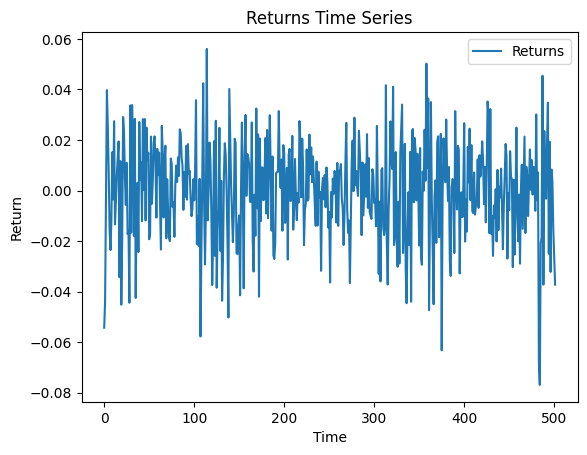

In [5]:
plt.plot(returns, label='Returns')
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.show()


The data as can be seen is really noisy.

We split the data into 80% training and 20% testing sets, common in ML to evaluate generalization. We use StandardScaler to normalize the input features (X) to have zero mean and unit variance, which helps neural nets train faster and more stably. Scaling is applied to test data using the training set’s parameters to avoid data leakage.

In [6]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)  # Debug
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # X_train: (n_train, 10)
X_test = scaler.transform(X_test)       # X_test: (n_test, 10)

X_train shape: (393, 10) X_test shape: (99, 10)


In [7]:
X_test.shape, y_test.shape

((99, 10), (99, 1))

We define a 3-layer MLP using PyTorch’s nn.Module. The model takes 10-day returns (input size 10), passes through two hidden layers (64 and 32 units) with ReLU activations, and outputs a single value (next-day return). We add an option for batch normalization (use_bn). If use_bn=True, we apply batch norm after each hidden layer; otherwise, we use nn.Identity (no-op). Batch norm normalizes layer outputs during training, reducing internal covariate shift

In [8]:
class MLP(nn.Module):
    def __init__(self, use_bn=False):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.bn1 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

Explanation: This function trains the MLP. For each epoch, we:

Set the model to training mode (model.train()).

Zero out gradients (optimizer.zero_grad()).

Forward pass: predict outputs from X_train.

Compute MSE loss (mean squared error, standard for regression).

Backpropagate (loss.backward()) and update weights (optimizer.step()).

In [9]:
def train_model(model, optimizer, X_train, y_train, epochs=100):
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        # Backprop
        loss.backward()
        optimizer.step()
    return losses


Explanation: We run experiments for four configurations: (SGD, no batch norm), (SGD, batch norm), (Adam, no batch norm), (Adam, batch norm). For each:

Initialize the MLP with/without batch norm.
Use SGD (lr=0.01) or Adam (lr=0.001) optimizers.
Train the model.
Evaluate on the test set, computing MSE.
Log MSE to wandb. This ablation study tests the impact of optimizers and batch norm on performance. Print results to compare

In [10]:
# Update the train_model function to store losses in a list
def train_model(model, optimizer, X_train, y_train, epochs=100):
    criterion = nn.MSELoss()
    losses = []  # Store loss per epoch
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  # Append loss to list
    return losses

In [11]:
# Update the main loop to remove wandb and use matplotlib
configs = [('SGD', False), ('SGD', True), ('Adam', False), ('Adam', True)]
results = {}
loss_histories = {}

for opt_name, use_bn in configs:
    print(f"Running config: Optimizer={opt_name}, BatchNorm={use_bn}")
    
    model = MLP(use_bn=use_bn)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01) if opt_name == 'SGD' else torch.optim.Adam(model.parameters(), lr=0.001)
    
    losses = train_model(model, optimizer, X_train, y_train)
    loss_histories[f'{opt_name}_BN={use_bn}'] = losses
    
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()
        mse = np.mean((y_pred.flatten() - y_test) ** 2)
    
    results[f'{opt_name}_BN={use_bn}'] = mse

print('Ablation Study Results:', results)

Running config: Optimizer=SGD, BatchNorm=False
Running config: Optimizer=SGD, BatchNorm=True
Running config: Optimizer=Adam, BatchNorm=False
Running config: Optimizer=Adam, BatchNorm=True
Ablation Study Results: {'SGD_BN=False': np.float64(0.004861409365408315), 'SGD_BN=True': np.float64(0.01579568854642415), 'Adam_BN=False': np.float64(0.001771324553369587), 'Adam_BN=True': np.float64(0.011744971288500983)}


In [12]:
# Build a DataFrame from the results dict
ablation_data = []

for config, mse in results.items():
    opt_name, bn_flag = config.split('_BN=')
    ablation_data.append({'Optimizer': opt_name, 'BatchNorm': bn_flag == 'True', 'Test MSE': round(mse, 6)})

df = pd.DataFrame(ablation_data)
df = df.sort_values(by=['Optimizer', 'BatchNorm']).reset_index(drop=True)

print("\n📊 Ablation Study Table:")
print(df.to_string(index=False))

# Optional: Save table
df.to_csv("ablation_results.csv", index=True)
df.to_latex("ablation_results.tex", index=True)  # For LaTeX report



📊 Ablation Study Table:
Optimizer  BatchNorm  Test MSE
     Adam      False  0.001771
     Adam       True  0.011745
      SGD      False  0.004861
      SGD       True  0.015796


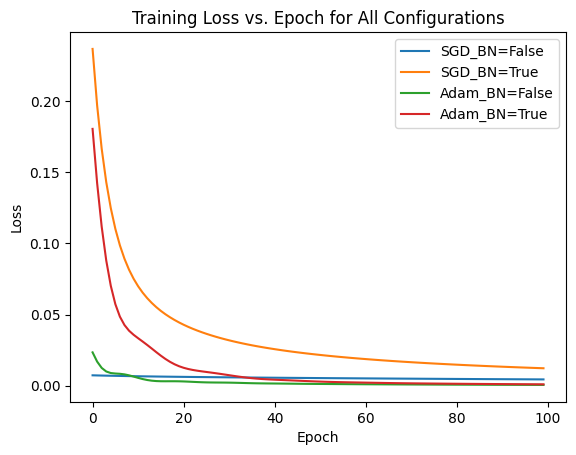

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot loss vs. epoch for all configs
for config, losses in loss_histories.items():
    plt.plot(range(len(losses)), losses, label=config)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epoch for All Configurations")
plt.legend()
plt.savefig("loss_plot.png")
plt.show()
plt.savefig("loss_plot.pdf")

We conducted an ablation comparing optimizers (SGD vs. Adam) and the use of batch normalization. Results show that Adam without batch normalization achieved the lowest test MSE (0.001771), outperforming all other configurations. Interestingly, batch normalization consistently degraded performance, suggesting its limited benefit in shallow MLP architectures for financial time-series prediction.

### Practicality

Can we use this model to earn some money? Not really. At least not without significant improvments. How to measure when an ml model feasible enough to be used in practice? There are several metrics to consider:
- **Sharpe Ratio**: Measures risk-adjusted return. A higher ratio indicates better risk-adjusted performance. It's calculated as the average return divided by the standard deviation of returns. A ratio above 1 is generally considered good.
- **Directional Accuracy**: Measures the percentage of times the model correctly predicts the direction of the price movement (up or down). A higher percentage indicates better predictive power.


In [14]:
pred_direction = np.sign(y_pred.flatten())
true_direction = np.sign(y_test)

accuracy = np.mean(pred_direction == true_direction)
print(f"Directional Accuracy: {accuracy:.2f}")

Directional Accuracy: 0.50


This means our model is no better than random guessing. To make it more practical, we could:
- Use more complex architectures (e.g., LSTM, GRU) that capture temporal dependencies better.
- Incorporate more features (e.g., technical indicators, macroeconomic data).
- Use ensemble methods to combine predictions from multiple models.